In [1]:
# Importing the necessary pacakages
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
# from kmodes.kprototypes import KPrototypes


In [2]:
# Loading the dataset
shopping_data = pd.read_csv("online_shoppers_intention.csv")
no_clusters = 4 # Number of clusters


In [3]:
# Performing initial inspection on the dataset
shopping_data.info()
# shopping_data.describe()
# shopping_data.columns()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12330 non-null int64
Administrative_Duration    12330 non-null float64
Informational              12330 non-null int64
Informational_Duration     12330 non-null float64
ProductRelated             12330 non-null int64
ProductRelated_Duration    12330 non-null float64
BounceRates                12330 non-null float64
ExitRates                  12330 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
Revenue                    12330 non-null bool
dtypes: bool(

In [4]:
# Operations on categorical features

print(shopping_data.Month.unique())
print(shopping_data.VisitorType.unique())
print(shopping_data.Weekend.unique())
print(shopping_data.Revenue.unique())

# Mean encoding of the VisitorType field
vt_me = shopping_data.groupby('VisitorType')['Revenue'].mean()
vt_me = round(vt_me, 3)
shopping_data['VisitorType'] = shopping_data['VisitorType'].map(vt_me)

weekend_dict = {True: 1, False: 0}
shopping_data['Weekend'] = shopping_data['Weekend'].map(weekend_dict)

revenue_dict = {True: 1, False: 0}
shopping_data['Revenue'] = shopping_data['Revenue'].map(revenue_dict)

# Mean encoding of the Month field
month_me = shopping_data.groupby('Month')['Revenue'].mean()
month_me = round(month_me, 3)
shopping_data['Month'] = shopping_data['Month'].map(month_me)


['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
['Returning_Visitor' 'New_Visitor' 'Other']
[False  True]
[False  True]


In [5]:
# Not considering the 'Revenue' field for the clustering
col_list = list(set(shopping_data.columns) - set(['Revenue']))
shopping_data_clustering = shopping_data[col_list].copy()


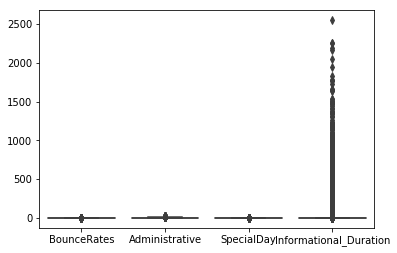

In [6]:
# Plotting the dataset to identify the outliers

sns.boxplot(data = shopping_data_clustering.iloc[:,[0,1,2,3]])
# sns.boxplot(data = shopping_data_clustering.iloc[:,[4,5,6,7]])
# sns.boxplot(data = shopping_data_clustering.iloc[:,[8,9,10,11]])
# sns.boxplot(data = shopping_data_clustering.iloc[:,[12,13,14,15]])
# sns.boxplot(data = shopping_data_clustering.iloc[:,[16]])

# The columns which might have outliers are -
# Administrative_Duration, ProductRelated_Duration, BounceRates, SpecialDay, PageValues, Informational_Duration


In [7]:
# Outlier processing
outlier_col = ['Administrative_Duration', 'ProductRelated_Duration', 'BounceRates', 'SpecialDay', 'PageValues', \
               'Informational_Duration']

for i in range(len(outlier_col)):    
    lv, uv = np.percentile(shopping_data_clustering[[outlier_col[i]]], [0,98])  
    shopping_data_clustering[[outlier_col[i]]] = np.clip(shopping_data_clustering[[outlier_col[i]]], lv, uv)


In [8]:
# Normalizing the features by MinMaxScaler. Didn't do feature scaling as it worsens the score
"""
scaler = StandardScaler()
shopping_data_clustering = scaler.fit_transform(shopping_data_clustering)

"""
print("")


In [9]:
# K-means algorithm
kmeans = KMeans(n_clusters = no_clusters, init = 'k-means++', n_jobs = -1)
kmeans_prediction = kmeans.fit_predict(shopping_data_clustering)


In [10]:
# Results from K-means algorithm
print(kmeans_prediction)
# print(kmeans.labels_) # Same as print(kmeans_prediction)
print(set(kmeans.labels_))
# print(kmeans.cluster_centers_)


[0 0 0 ... 0 0 0]
{0, 1, 2, 3}


In [11]:
# Evaluation metrics - Rand Index (K-means)

km_ri_start = time.time()

kmeans_predict_list = list(kmeans_prediction)
revenue_list = list(shopping_data['Revenue'])

s, d = (0,0)
for i in range(len(kmeans_predict_list)):
    for j in range(i+1, len(kmeans_predict_list)):
        if ((kmeans_predict_list[i] == kmeans_predict_list[j]) & (revenue_list[i] == revenue_list[j])):
            s += 1
        elif ((kmeans_predict_list[i] != kmeans_predict_list[j]) & (revenue_list[i] != revenue_list[j])):
            d += 1

kmeans_ri = 2*(s+d)/(len(kmeans_predict_list)*(len(kmeans_predict_list) - 1))

km_ri_end = time.time()

print("Execution time (in seconds) to compute RI for k-means is:", round(km_ri_end - km_ri_start, 2))
print("Rand index for K-means is:", round(kmeans_ri, 3))


Execution time (in seconds) to compute RI for k-means is: 173.86
Rand index for K-means is: 0.516


In [12]:
# Evaluation metrics - Davies-Bouldin Index (K-means), Steps involed in computing the Davies Bauldin Index are:
# Step 1: Calculating centroid of each cluster (K-means)

km_dbi_start = time.time()

shopping_data_clustering['kmeans_prediction'] = pd.Series(kmeans_predict_list)
kmeans_centroids = shopping_data_clustering.groupby(['kmeans_prediction']).mean()
kmeans_centroids = kmeans_centroids.reset_index()


In [13]:
# 2.) Calculating the avg(C) of a cluster, i.e. average distance b/w points in the cluster (K-means)
kmeans_avg_C = np.zeros(no_clusters)

for i in range(no_clusters):
    temp_df = shopping_data_clustering[shopping_data_clustering['kmeans_prediction'] == i].iloc[:,:-1]
    
    if len(temp_df) > 1:
        kmeans_avg_C[i] = round(np.sum(pairwise_distances(temp_df))/((len(temp_df))*(len(temp_df) - 1)), 2)
    else:
        kmeans_avg_C[i] = 0
    
# print(kmeans_avg_C)


In [14]:
# Step 3: d_cen(mu_i,mu_j) i.e. distance between the centroids of 2 clusters (K-means).
kmeans_d_cen = np.zeros((no_clusters, no_clusters))

for i in range(no_clusters):
    for j in range(i+1, no_clusters):
        d = 0
        for l in range(1, len(kmeans_centroids.columns)):
            d += (kmeans_centroids.iloc[i,l] - kmeans_centroids.iloc[j,l])**2
        kmeans_d_cen[i][j] = kmeans_d_cen[j][i] = round(d**0.5, 2)


In [15]:
# Step 4: Computing DBI Index for K-means
kmeans_dbi = 0
for i in range(no_clusters):
    max_val = 0
    for j in range(no_clusters):
        if (i != j):
            temp_val = (kmeans_avg_C[i] + kmeans_avg_C[j])/kmeans_d_cen[i][j]
            if (max_val < temp_val):
                max_val = temp_val
            
    kmeans_dbi += max_val

kmeans_dbi = round(kmeans_dbi/no_clusters, 3)

km_dbi_end = time.time()
print("Execution time (in seconds) to compute DBI for k-means is:", round(km_dbi_end - km_dbi_start, 2))

print("DBI for K-means is:", kmeans_dbi)


Execution time (in seconds) to compute DBI for k-means is: 1.08
DBI for K-means is: 0.722


In [16]:
# Dropping the engineered columns before starting new clustering
shopping_data_clustering = shopping_data_clustering.drop(['kmeans_prediction'], axis = 1)


In [17]:
# Agglomerative Clustering algorithm
agg_cluster = AgglomerativeClustering(n_clusters = no_clusters, linkage = 'complete')
agg_cluster_prediction = agg_cluster.fit_predict(shopping_data_clustering)


In [18]:
# Results from Agglomerative Clustering algorithm
print(agg_cluster_prediction)
# print(agg_cluster.labels_)
print(set(agg_cluster.labels_))

# Element value counts of each clusters
print("")
print(pd.Series(agg_cluster_prediction).value_counts())


[2 2 2 ... 2 2 2]
{0, 1, 2, 3}

2    10185
3      896
1      675
0      574
dtype: int64


In [19]:
# Evaluation metrics - Rand Index (Agglomerative Clustering)
agnest_ri_start = time.time()

agg_cluster_predict_list = list(agg_cluster_prediction)
revenue_list = list(shopping_data['Revenue'])  # This list is already created once

s, d = (0,0)
for i in range(len(agg_cluster_predict_list)):
    for j in range(i+1, len(agg_cluster_predict_list)):
        if ((agg_cluster_predict_list[i] == agg_cluster_predict_list[j]) & (revenue_list[i] == revenue_list[j])):
            s += 1
        elif ((agg_cluster_predict_list[i] != agg_cluster_predict_list[j]) & (revenue_list[i] != revenue_list[j])):
            d += 1

AC_ri = 2*(s+d)/(len(agg_cluster_predict_list)*(len(agg_cluster_predict_list) - 1))
AC_ri = round(AC_ri, 3)

agnest_ri_end = time.time()
print("Execution time (in seconds) to compute RI for AGNEST is:", round(agnest_ri_end - agnest_ri_start, 2))

print("Rand index for Agglomerative Clustering is:", AC_ri)


Execution time (in seconds) to compute RI for AGNEST is: 154.46
Rand index for Agglomerative Clustering is: 0.633


In [20]:
# Evaluation metrics - Davies-Bouldin Index (Agglomerative Clustering).
# Steps involed in computing the Davies Bauldin Index are:
# Step 1: Calculating centroid of each cluster (Agglomerative Clustering)
agnest_dbi_start = time.time()

shopping_data_clustering['ac_prediction'] = pd.Series(agg_cluster_predict_list)
AC_centroids = shopping_data_clustering.groupby(['ac_prediction']).mean()
AC_centroids = AC_centroids.reset_index()


In [21]:
# 2.) Calculating the avg(C) of a cluster, i.e. average distance b/w points in the cluster (Agglomerative Clustering)
AC_avg_C = np.zeros(no_clusters)

for i in range(no_clusters):
    temp_df = shopping_data_clustering[shopping_data_clustering['ac_prediction'] == i].iloc[:,:-1]
    
    if len(temp_df) > 1:
        AC_avg_C[i] = round(np.sum(pairwise_distances(temp_df))/((len(temp_df))*(len(temp_df) - 1)), 2)
    else:
        AC_avg_C[i] = 0

# print(AC_avg_C)


In [22]:
# Step 3: d_cen(mu_i,mu_j) i.e. distance between the centroids of 2 clusters (Agglomerative Clustering).
AC_d_cen = np.zeros((no_clusters, no_clusters))

for i in range(no_clusters):
    for j in range(i+1, no_clusters):
        d = 0
        for l in range(1, len(AC_centroids.columns)):
            d += (AC_centroids.iloc[i,l] - AC_centroids.iloc[j,l])**2
        AC_d_cen[i][j] = AC_d_cen[j][i] = d**0.5


In [23]:
# Step 4: Finally computing DBI Index for Agglomerative Clustering
AC_dbi = 0
for i in range(no_clusters):
    max_val = 0
    for j in range(no_clusters):
        if (i != j):
            temp_val = (AC_avg_C[i] + AC_avg_C[j])/AC_d_cen[i][j]
            if (max_val < temp_val):
                max_val = temp_val
            
    AC_dbi += max_val

AC_dbi = round(AC_dbi/no_clusters, 3)

agnest_dbi_end = time.time()
print("Execution time (in seconds) to compute DBI for AGNEST is:", round(agnest_dbi_end - agnest_dbi_start, 2))

print("DBI for Agglomerative Clustering is:", AC_dbi)


Execution time (in seconds) to compute DBI for AGNEST is: 1.41
DBI for Agglomerative Clustering is: 0.759


In [24]:
# Conclusions
print("Rand index for K-Means is:", round(kmeans_ri, 3))
print("Rand index for Agglomerative Clustering is:", AC_ri)

if kmeans_ri > AC_ri:
    print("K_Means is better than Agglomerative Clustering in RI metric")
elif kmeans_ri < AC_ri:
    print("Agglomerative Clustering is better than K-Means in RI metric")
else:
    print("RI metric for both Agglomerative Clustering and K-Means are same")

print()
print('-'*75)
print()

print("DBI for K-Means Clustering is:", kmeans_dbi)
print("DBI for Agglomerative Clustering is:", AC_dbi)

if kmeans_dbi < AC_dbi:
    print("K_Means is better than Agglomerative Clustering in DBI metric")
elif kmeans_dbi > AC_dbi:
    print("Agglomerative Clustering is better than K-Means in DBI metric")
else:
    print("DBI metric for both Agglomerative Clustering and K-Means are same")


Rand index for K-Means is: 0.516
Rand index for Agglomerative Clustering is: 0.633
Agglomerative Clustering is better than K-Means in RI metric

---------------------------------------------------------------------------

DBI for K-Means Clustering is: 0.722
DBI for Agglomerative Clustering is: 0.759
K_Means is better than Agglomerative Clustering in DBI metric
